# Conway's Game of Life

This is a demonstration of the game of life as an agent-based model.

We start with importing some libraries.

In [1]:
using AlgebraicRewriting
using Catlab, Catlab.Graphs, Catlab.CategoricalAlgebra, Catlab.Theories
import Catlab.Graphics: to_graphviz
using Catlab.Graphics.Graphviz: Attributes, Statement, Node, Edge, Digraph
using PrettyTables
using Luxor

The game of life has two rules: one which turns living things dead, and one that brings dead things to life. We model the terrain as a symmetric graph: cells are vertices. Neighboring cells have edges between them.

Implementation wise, if we are going to update cells one at a time, we must keep track of two bits of information (the cell's living status for the *current* timestep and whether it will be alive in the *next* timestep). Thus we need helper rule to overwrite the "current" life status with the "next" life status at the end of each timestep.

# Ontology

Defining an ontology is stating what data is required to specify a state of the
simulation at some point in time. In AlgebraicJulia, this is done via declaring
a `Presentation`, i.e. a database schema. Objects (`Ob`, or tables) are types of
entities. Homs (`Hom`, or foreign keys) are functional relationships between the
aforementioned entities. AttrTypes are placeholders for Julia types, which are
assigned to `Ob` via attributes (`Attr`).

The schema below extends the schema for directed symmetric graphs, which
consists in two tables (`E` and `V`, for edges and vertices) and two homs
(`src` and `tgt`, `E→V`). Furthermore a hom `inv: E→E` enforces that each edge
is paired with its opposite-pointing edge.

The schema below says there are two more types of entities, `Curr` and `Next`.
Think of these as little tokens that can be assigned to vertices to mark them
as currently-alive or to-be-alive-in-the-next-timestep, respectively. Thus, we
can also thinking of them as picking out *subsets* of `V` via the maps `curr`
and `next`.

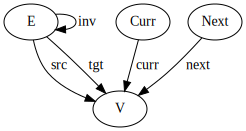

In [2]:
@present SchLife <: SchSymmetricGraph begin
  (Curr, Next)::Ob
  curr::Hom(Curr, V)
  next::Hom(Next, V)
end

@acset_type Life(SchLife, part_type=BitSetParts) <: AbstractSymmetricGraph

to_graphviz(SchLife; prog="dot")

We can further extend this schema with an additional attribute of (x,y)
coordinates for every vertex. This is nice for visualization but is otherwise
unnecessary when doing the actual agent-based modeling. So what we will do is
*build* our model with the Life schema and then *run* our model with the
LifeCoords schema.

In [3]:
@present SchLifeCoords <: SchLife begin
  Coords::AttrType
  coords::Attr(V, Coords)
end

@acset_type AbsLifeCoords(SchLifeCoords, part_type=BitSetParts) <: AbstractSymmetricGraph

const LifeCoords = AbsLifeCoords{Tuple{Int,Int}};

# Data migration functors

We ought to be able to take a state of the world (with no coordinate information)
and obtain a state of the world with coordinates (the canonical way to do this
is to assign "variables" for the values of the coordinates).

In [4]:
F = Migrate(SchLifeCoords, LifeCoords; delta=false); # adds coordinates

F⁻¹ = DeltaMigration(FinFunctor(idₒ, idₘ, SchLife, SchLifeCoords)); # removes coordinates

# Helper functions

Functions to help us create a grid.

In [5]:
function make_grid(curr::AbstractMatrix, next=nothing)
  n, m = size(curr)
  n == m || error("Must be square")
  X, coords = LifeCoords(), Dict()
  for i in 1:n
    for j in 1:n
      coords[i=>j] = add_vertex!(X; coords=(i, j))
      if Bool(curr[i, j])
        add_part!(X, :Curr, curr=coords[i=>j])
      end
      if !isnothing(next) && Bool(next[i, j])
        add_part!(X, :Curr, curr=coords[i=>j])
      end
    end
  end
  for i in 1:n
    for j in 1:n
      if i < n
        add_edge!(X, coords[i=>j], coords[i+1=>j])
      end
      if j < n
        add_edge!(X, coords[i=>j], coords[i=>j+1])
      end
      if i < n && j < n
        add_edge!(X, coords[i=>j], coords[i+1=>j+1])
      end
      if i < n && j > 1
        add_edge!(X, coords[i=>j], coords[i+1=>j-1])
      end
    end
  end
  X
end

make_grid(n::Int, random=false) = make_grid((random ? rand : zeros)(Bool, (n, n)));

Functions to help us visualize a grid. Although we have no such constraint, we'll expect any `LifeCoords` instance to be a regular grid (for the purposes of visualization). When
that's the case, we can visualize the game state using plaintext.

In [6]:
function view_life(f::ACSetTransformation, pth=tempname())
  v = collect(f[:V])
  view_life(codom(f), pth; star=isempty(v) ? nothing : only(v))
end

function view_life(X::LifeCoords, pth=tempname(); star=nothing)
  n = Int(sqrt(nparts(X, :V)))
  coords = Dict([(i, j) => findfirst(==((i, j)), X[:coords])
                 for (i, j) in Iterators.product(1:n, 1:n)])
  mat = pretty_table(String, reduce(hcat, map(1:n) do i
      map(1:n) do j
        c, x = [!isempty(incident(X, coords[(i, j)], x)) for x in [:curr, :next]]
        res = c ? (x ? "O" : "o") : (x ? "X" : "x")
        return res * ((star == coords[(i, j)]) ? "." : "")
      end
    end); show_header=false, tf=tf_markdown)
  open(pth, "w") do io
    write(io, mat)
  end
  return mat
end

init = make_grid(3,  true)
view_life(init) |> println

| x | o | o |
| x | o | x |
| o | x | x |



We can also visualize a grid with a distinguished *agent*. Here an agent living in a game state `X` is a map `A → X` where `A` is the shape of the agent. The only kind of agent we'll consider in this model is that of a lone vertex.

Note that `A` below is defined without coordinates, whereas `init` is an
instance of `LifeCoords`. So in order to relate them via a mapping (which
requires them to share a schema) we promote `A` to `LifeCoords` using the
data migration, `F`.

In [7]:
A = Life(1)
view_life(homomorphism(F(A), init)) |> println

| x. | o | o |
|  x | o | x |
|  o | x | x |



We must also work with miniature game states that are *not* grids in order for
us to define the dynamics, as they are what the patterns and replacements of
rewrite rules are made of. In order to visualize these, we will use another
visualization function.

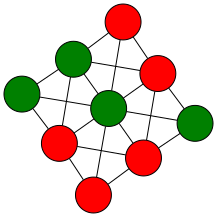

In [8]:
function view_life_graph(X::Union{Life,LifeCoords}, pth=tempname(); star=nothing)
  pg = PropertyGraph{Any}(; prog="neato", graph=Dict(),
    node=Dict(:shape => "circle", :style => "filled", :margin => "0"),
    edge=Dict(:dir => "none", :minlen => "1"))
  add_vertices!(pg, nparts(X, :V))
  for v in vertices(X)
    set_vprop!(pg, v, :fillcolor, isempty(incident(X, v, :curr)) ? "red" : "green")
    isempty(incident(X, v, :next)) || set_vprop!(pg, v, :penwidth, "4.0")
    set_vprop!(pg, v, :label, star == v ? "*" : "")
  end
  for e in filter(e -> X[e, :inv] > e, edges(X))
    add_edge!(pg, X[e, :src], X[e, :tgt])
  end
  G = to_graphviz(pg)
  open(pth, "w") do io
    show(io, "image/svg+xml", G)
  end
  G
end;

view_life_graph(init)

Now we make some helper functions to construct important ACSets and
maps between them. We start with a single vertex which is marked as to-be-alive
in the next time step.

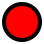

In [9]:
Next() = @acset Life begin V = 1; Next = 1; next = 1 end;

view_life_graph(Next())

We also want to refer to a vertex which is alive in the current time step

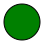

In [10]:
Curr() = @acset Life begin V = 1; Curr = 1; curr = 1 end;
view_life_graph(Curr())

We also want these where we have a morphism incoming from a vertex.

In [11]:
to_next() = homomorphism(Life(1), Next());
to_curr() = homomorphism(Life(1), Curr());

We make a helper for cells connected to `n` living neighbors

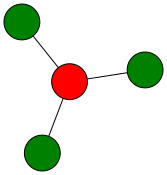

In [12]:
function living_neighbors(n::Int; alive=false)
  X = Life(1)
  alive &&  add_part!(X, :Curr, curr=1)
  for _ in 1:n
    v = add_part!(X, :V)
    add_part!(X, :Curr, curr=v)
    add_edge!(X, v, 1)
  end
  X
end

view_life_graph(living_neighbors(3))

We can control whether the central cell is itself alive or not

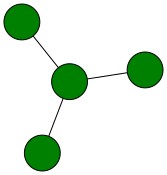

In [13]:
view_life_graph(living_neighbors(3; alive=true))

# Rules

We have finished specifying what makes up a simulation state, and next is to
define what sorts of transitions are possible. This is done by declaring
rewrite rules.

### A dead cell becomes alive iff exactly 3 living neighbors

In [14]:
BirthP1 = living_neighbors(3) # must have 3 neighbors
BirthN1 = living_neighbors(4) # forbid the cell to have 4 neighbors
BirthN2 = Curr() # forbid the cell to be alive (i.e. it's currently dead)
BP1, BN1, BN2 = homomorphism.(Ref(Life(1)), [BirthP1, BirthN1, BirthN2])
bac = [AppCond(BP1; monic=true), AppCond.([BN1, BN2], false; monic=true)...]
Birth = Rule(id(Life(1)), to_next(); ac=bac);

### A living cell stays alive iff 2 or 3 living neighbors

In [15]:
PersistR = @acset Life begin
  V = 1; Curr = 1; Next = 1; curr = 1; next = 1
end
PersistP1 = living_neighbors(2; alive=true)
PersistN1 = living_neighbors(4; alive=true)
DR, DP1, DN1 = homomorphism.(Ref(Curr()), [PersistR, PersistP1, PersistN1])
pac = [AppCond(DP1; monic=true), AppCond(DN1, false; monic=true)]
Persist = Rule(id(Curr()), DR; ac=pac);

### remove "Curr" status

In [16]:
ClearCurr = Rule(to_curr(), id(Life(1)));

### remove "Next" status

In [17]:
ClearNext = Rule(to_next(), id(Life(1)));

### Copy "Next" to "Curr"

In [18]:
CopyNext = Rule(to_next(), to_curr());

## Assembling rules into a recipe

Now we can assemble our building blocks into a large wiring diagram
characterizing the flow of the overall ABM simulation. In addition
to the blue rewrite rule blocks, we have yellow `Query` blocks which execute
subroutines once per agent (the second output wire) before exiting (the first
output wire).

Give symbolic names to the rewrite rules from before

In [19]:
rules = [:Birth => Birth, :Persist => Persist, :ClearCurr => ClearCurr,
  :ClearNext => ClearNext, :CopyNext => CopyNext];

All rules have interface of a single distinguished cell, i.e. they are executed
from the perspective an agent which is a particular distinguished vertex.

Normally we can consider branching possibilities depending on whether or not the
rewrite is successful, but in this simulation we don't do this. `tryrule` simply
merges the two output wires from a rewrite rule box into a single output wire.

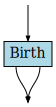

In [20]:
rBirth, rPersist, rClearCurr, rClearNext, rCopyNext =
  [tryrule(RuleApp(n, r, Life(1))) for (n, r) in rules]

view_sched(rBirth)

The first `for` loop is computing `next` for all cells

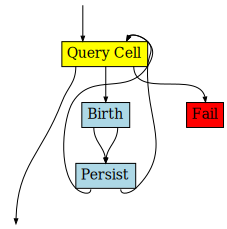

In [21]:
update_next = agent(rBirth ⋅ rPersist, Life(1); n=:Cell)

view_sched(update_next)

The second `for` loop is overwriting `curr` with `next` for all cells

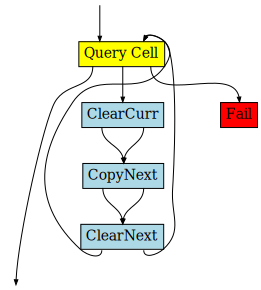

In [22]:
next_step = agent(compose(rClearCurr, rCopyNext, rClearNext), Life(1); n=:Cell)

view_sched(next_step)

We then compose these together and wrap in an overall `for` loop with a counter.

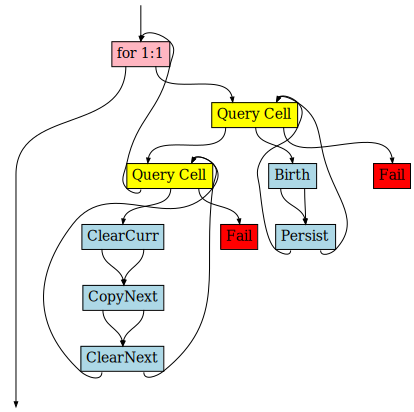

In [23]:
life(n::Int) = for_schedule(update_next ⋅ next_step, n) |> F

const L = life(1) # Game of life simulation that runs just one (global) timestep

view_sched(L)

## Running the simulation

Make an initial state

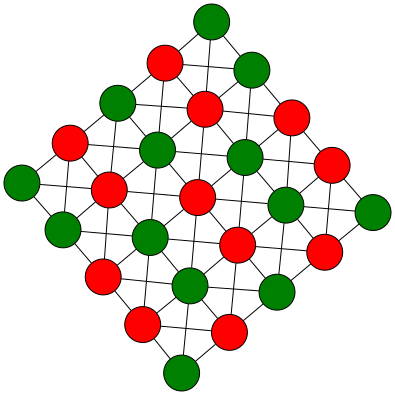

In [24]:
G = make_grid([1 0 1 0 1; 0 1 0 1 0; 0 1 0 1 0; 1 0 1 0 1; 1 0 1 0 1])

view_life_graph(G)

(or, viewed in plaintext)

In [25]:
view_life(G) |> println

| o | x | x | o | o |
| x | o | o | x | x |
| o | x | x | o | o |
| x | o | o | x | x |
| o | x | x | o | o |



Run the simulation

In [26]:
res = interpret(L, G; maxstep=1000);

Look at the end state

In [27]:
res[end][1] |> codom |> view_life |> println

| x | o | o | o | x |
| o | o | o | x | x |
| o | x | x | o | x |
| o | o | o | x | x |
| x | o | o | o | x |



Visualize the results in the `traj` folder

In [28]:
view_traj(L, res[1:10], view_life; agent=true)